## 誤差補正関数について簡易実験

In [1]:
from tqdm import tqdm

import numpy as np
from pandas import DataFrame
from scipy.stats import spearmanr, rankdata, hmean
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

def sigmoid(x: np.ndarray) -> np.ndarray:
    return np.exp(np.minimum(x, 0)) / (1.0 + np.exp(-np.abs(x)))

In [2]:
# 実験設定
num_users = 60000 # ユーザ数
num_jobs = 1000 # 企業数
k = 100
np.random.seed(12345)

# 真のマッチ確率を作っておく
u2j = sigmoid(np.random.normal(-4, 1, size=(num_users, num_jobs)))
j2u = sigmoid(np.random.normal(-1.5, 1, size=(num_users, num_jobs)))
pmatch = u2j * j2u

In [3]:
(u2j.mean(), j2u.mean(), pmatch.mean())

(0.02809911680998552, 0.22143771496688258, 0.006222147438049482)

In [7]:
# 実験をまわす
naive_prec_list = []
harmo_prec_list = []
norm_prec_list = []
rank_prec_list = []
srank_prec_list = []
for noise_level in tqdm(range(5, 20)):
    # 適当に予測誤差を追加
    u2j_noise = u2j + np.random.uniform(-u2j / noise_level, u2j / noise_level)
    j2u_noise = j2u + np.random.uniform(-j2u / (20 - noise_level), j2u / (20 - noise_level))

    # 単純積
    naive = u2j_noise * j2u_noise
    naive_prec_list.append((pmatch * np.int32(rankdata(naive, axis=1) <= k)).sum(1).mean())

    # 調和平均
    harmo = 2 / ((1 / u2j_noise) + (1 / j2u_noise))
    harmo_prec_list.append((pmatch * np.int32(rankdata(harmo, axis=1) <= k)).sum(1).mean())

    # 標準偏差による正規化
    u2j_noise_ = u2j_noise / u2j_noise.std(1)[:, np.newaxis]
    j2u_noise_ = j2u_noise / j2u_noise.std(0)[np.newaxis]
    norm = u2j_noise_ * j2u_noise_
    norm_prec_list.append((pmatch * np.int32(rankdata(norm, axis=1) <= k)).sum(1).mean())

    # 逆順の逆数
    u2j_noise_rank = 1. / rankdata(u2j_noise, axis=1)
    j2u_noise_rank = 1. / rankdata(j2u_noise, axis=0)
    rank = u2j_noise_rank * j2u_noise_rank
    rank_prec_list.append((pmatch * np.int32(rankdata(rank, axis=1) <= k)).sum(1).mean())

    # 正規化された順位の逆数
    # u2j_noise_rank_ = u2j_noise_rank / u2j_noise.std(1)[:, np.newaxis]
    # j2u_noise_rank_ = j2u_noise_rank / j2u_noise.std(0)[np.newaxis]
    # norm_rank = u2j_noise_rank_ * j2u_noise_rank_
    # srank_prec_list.append((pmatch * np.int32(rankdata(norm_rank, axis=1) <= k)).sum(1).mean())

    # 現在使われているrank
    u2j_noise_rank_ = 1. - rankdata(-u2j_noise, axis=1) / num_jobs
    j2u_noise_rank_ = 1. - rankdata(-j2u_noise, axis=0) / num_users
    norm_rank = u2j_noise_rank_ * j2u_noise_rank_
    srank_prec_list.append((pmatch * np.int32(rankdata(norm_rank, axis=1) <= k)).sum(1).mean())

100%|██████████| 15/15 [10:51<00:00, 43.41s/it]


In [5]:
result = DataFrame(
    [
        naive_prec_list, harmo_prec_list, norm_prec_list, rank_prec_list, srank_prec_list
    ],
    index=["naive", "harmo", "norm", "rank_inv", "rank_now"],
    columns=range(5, 20),
).T

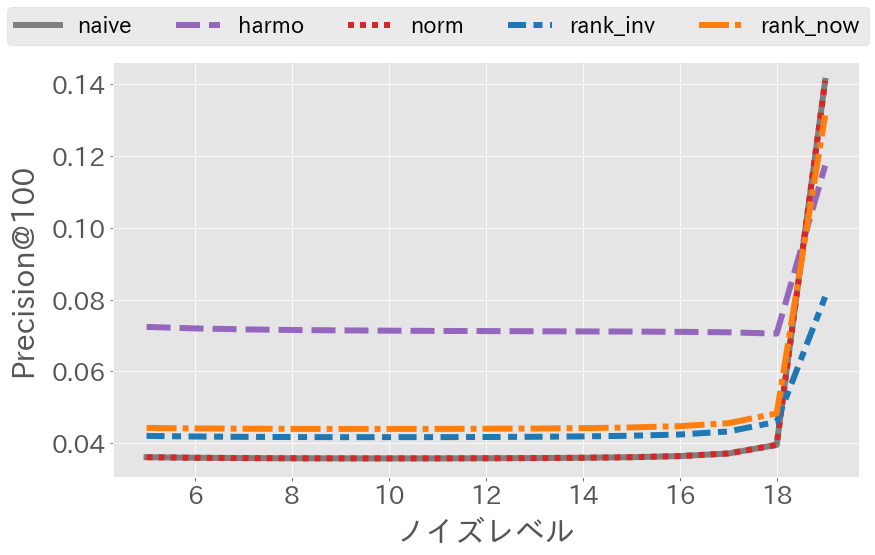

In [9]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12, 7), tight_layout=True)
sns.lineplot(
    linewidth=6,
    linestyle="-",
    ax=ax,
    palette=["tab:grey","tab:purple", "tab:red", "tab:blue", "tab:orange"],
    legend=False,
    data=result,
)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel(f"Precision@{k}", fontsize=30)
ax.tick_params(axis="y", labelsize=25)
ax.yaxis.set_label_coords(-0.1, 0.5)
# xaxis
ax.set_xlabel(r"ノイズレベル", fontsize=30)
ax.tick_params(axis="x", labelsize=25)
ax.xaxis.set_label_coords(0.5, -0.1)
fig.legend(
    ["naive", "harmo", "norm", "rank_inv", "rank_now"], fontsize=22,
    bbox_to_anchor=(0.5, 1.05), ncol=5, loc="center",
)